In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

from sklearn.metrics import confusion_matrix
import pandas as np
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# Convert MNIST image files to 4D tensors (# images, height, width, colour)
transform = transforms.ToTensor()

In [8]:
# train data
train_data = datasets.MNIST(root='cnn_data',
                            train=True, 
                            download=True, 
                            transform=transform
                           )

# test data
test_data = datasets.MNIST(root='cnn_data',
                            train=False, 
                            download=True, 
                            transform=transform
                           )

In [9]:
# create small batch size for images
train_loader = DataLoader(train_data,
                          batch_size=10,
                          shuffle=True
                         )

test_loader = DataLoader(test_data,
                         batch_size=10,
                         shuffle=False
                        )


In [10]:
# model class
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # convolutional layers
        self.conv1 = nn.Conv2d(1,6,3,1)
        self.conv2 = nn.Conv2d(6,16,3,1)
        # fully connected layers; numbers here don't matter bar first input and last output
        self.fc1 = nn.Linear(5*5*16,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)

    def forward(self,X):
        #first pass
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2,2) # 2x2 kernel; stride of 2
        # second pass
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2,2) # 2x2 kernel; stride of 2

        # re-view data to flatten it
        X = X.view(-1,16*5*5)  # -1 so batch size can be varied

        # fully connected layers
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)

        # F.log_softmax basically returns weights between 0-1 (softmax). log then essentially
        # makes the weights a log-likelihood space rather than likelihood space. When applying
        # the criterion this is important because using the log-softmax will punish bigger 
        # mistakes in likelihood space higher than just a softmax.
        return F.log_softmax(X, dim=1)

In [11]:
# create instance of model
torch.manual_seed(41)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [12]:
# Loss function optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) # smaller learning rate, longer training time


In [16]:
import time
start_time = time.time()


# create variables to track things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# for loop of epochs
for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    # train
    for b,(X_train,y_train) in enumerate(train_loader):
        b+= 1 # start batches at 1
        y_pred  = model(X_train) # get predicted values from training set. 2D, not flattened
        loss = criterion(y_pred, y_train) # compare actual and predicted values during training

        predicted = torch.max(y_pred.data,1)[1] # sum correct number of predictions. Indexed off the first point
        batch_corr = (predicted == y_train).sum() # how many we got correct from this batch. True = 1; False = 0.
        trn_corr += batch_corr # keep track as we train

        # update params
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print results
        if b % 600 == 0:
            print(f'Epoch: {i+1} \t Batch: {b} \t Loss {loss.item()}')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # test
    with torch.no_grad(): # no gradient so we don't update weights and biases with test data
        for b,(X_test,y_test) in enumerate(test_loader):
            y_val = model(X_test)
            predicted = torch.max(y_val.data, 1)[1] # adding up correct predictions
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val,y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)


# track how long it takes to run
current_time = time.time()
total = current_time - start_time
print(f'Training Time: {np.round(total/60,3)} minutes.')

Epoch: 1 	 Batch: 600 	 Loss 0.012505684979259968
Epoch: 1 	 Batch: 1200 	 Loss 0.05883730575442314
Epoch: 1 	 Batch: 1800 	 Loss 0.012552308849990368
Epoch: 1 	 Batch: 2400 	 Loss 0.1156829446554184
Epoch: 1 	 Batch: 3000 	 Loss 0.003958164714276791
Epoch: 1 	 Batch: 3600 	 Loss 0.023223768919706345
Epoch: 1 	 Batch: 4200 	 Loss 0.13725486397743225
Epoch: 1 	 Batch: 4800 	 Loss 0.017414644360542297
Epoch: 1 	 Batch: 5400 	 Loss 0.019625717774033546
Epoch: 1 	 Batch: 6000 	 Loss 0.0009632919100113213
Epoch: 2 	 Batch: 600 	 Loss 0.020942356437444687
Epoch: 2 	 Batch: 1200 	 Loss 0.007455732673406601
Epoch: 2 	 Batch: 1800 	 Loss 0.053520072251558304
Epoch: 2 	 Batch: 2400 	 Loss 0.22848239541053772
Epoch: 2 	 Batch: 3000 	 Loss 0.03699440509080887
Epoch: 2 	 Batch: 3600 	 Loss 0.00020113571372348815
Epoch: 2 	 Batch: 4200 	 Loss 0.0002936032833531499
Epoch: 2 	 Batch: 4800 	 Loss 0.0008488165331073105
Epoch: 2 	 Batch: 5400 	 Loss 0.008420052006840706
Epoch: 2 	 Batch: 6000 	 Loss 0.00

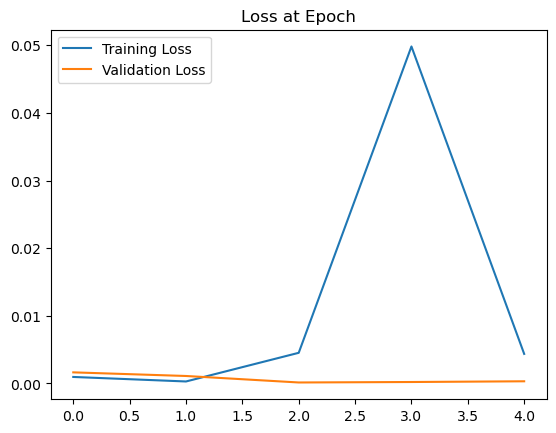

In [17]:
# graph the loss at each epoch
train_losses = [tl.item() for tl in train_losses]
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.title('Loss at Epoch')
plt.legend()

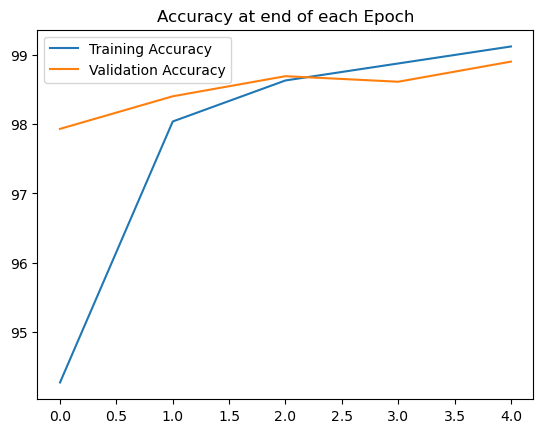

In [18]:
# graph accuracy at end of each epoch
plt.plot([t/600 for t in train_correct], label='Training Accuracy')
plt.plot([t/100 for t in test_correct], label='Validation Accuracy')
plt.title('Accuracy at end of each Epoch')
plt.legend()

In [19]:
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)

In [20]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_everything:
        y_val = model(X_test)
        predicted = torch.max(y_val, 1)[1]
        correct += (predicted == y_test).sum()

In [23]:
# Did for correct
correct.item()/len(test_data)*100

98.9

In [24]:
# grab an image
test_data[4143] # tensor with image in it and shows the label; 9.

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [25]:
# grab just data
test_data[4143][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

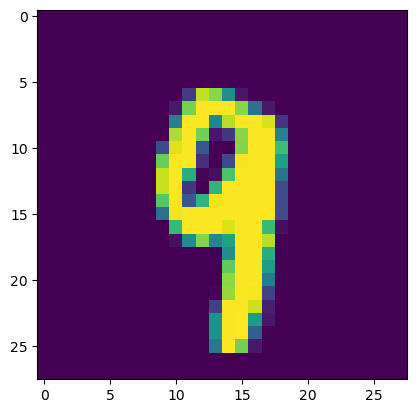

In [26]:
# reshape
test_data[4143][0].reshape(28,28)

#show image
plt.imshow(test_data[4143][0].reshape(28,28))

In [27]:
# pass image through model
model.eval()
with torch.no_grad():
    new_prediction = model(test_data[4143][0].view(1,1,28,28))

In [28]:
# check new prediciton
new_prediction

tensor([[-1.9827e+01, -1.8521e+01, -2.3113e+01, -1.8620e+01, -1.1780e+01,
         -1.9932e+01, -2.7470e+01, -1.6109e+01, -1.3537e+01, -9.0599e-06]])

In [29]:
new_prediction.argmax() # got the right answer

tensor(9)